Script para generar dato sísmico sintético basado en el modelo convolucional.
El modelo de subsuelo puede ser capas planas o con pendientes generando cuñas
y se puede optar por el tipo de ondícula a utilizar. 

Autor: Gabriel Gelpi


In [135]:
import numpy as np
import matplotlib.pyplot as plt
from rickerpy import rickerpy
import scipy.signal as ss


# para que los gráficos queden todos con el mismo tipo de letra:
from matplotlib import rcParams
rcParams['text.usetex'] = True
plt.rc('font', family='sans')# Otro tipo de letras son "serif","monospace","sans", etc...
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'lines.linewidth':1.})

La ondícula puede ser cargada desde un archivo ascii o se puede utilizar una genérica como Ricker u Ormsby

In [136]:
longi = 108 # long en tiempo
f0 = 30     # frecuencia central
dt = 2      # intervalo de muestreo en ms

wavelet = rickerpy(longi,dt,f0)     # genero la ondicula
wl = wavelet.shape[0]               # largo de la ondicula en muestras
   
fase = -30                          # rotacion a la fase
angles = np.radians(fase)
wavelet_rot = np.zeros((wl,1))
wavelet_rot = np.cos(angles)*wavelet[:,0]-np.sin(angles)*np.imag(ss.hilbert(wavelet[:,0])) #THG

Gráficos de las ondículas de fase cero y con la rotación elegida

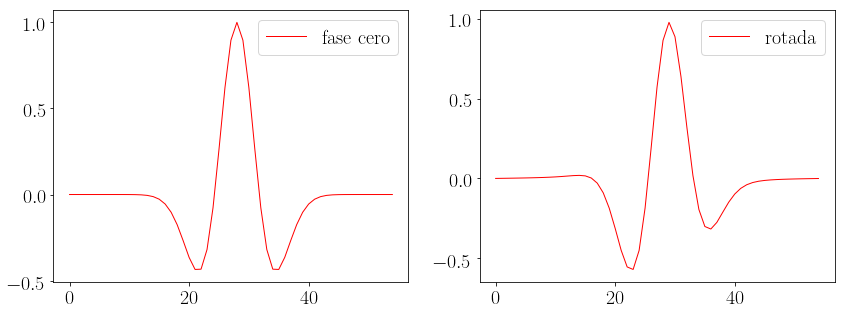

In [137]:
fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].plot(wavelet,'r',label="fase cero")
ax[0].legend()
ax[1].plot(wavelet_rot,'r', label="rotada")
ax[1].legend()

plt.show()

Elejimos el modelo del subsuelo. 

In [138]:
nr = 300        # Nro de muestras de la reflectividad
ntr = 21        # numero de reflectividades (nro de trazas)

R = np.zeros((nr,ntr)) 

#R[15,:] = 0.2
R[25,:] = 0.3
for i in range(0,ntr):
    R[50+i,i] = 1
    
R[70,:] = 0.1
R[105,:] = 0.7
R[155,:] = -0.1
R[200,:] = -0.2
R[210,:] = -0.15


Para generar las trazas convolucionamos la ondícula con cada una de las reflectividades. Observar que es un sintético sencillo y que este dato resultante no tiene ruido. 

In [139]:
dl = nr+wl-1 # nro de elementos que va a tener las trazas generadas.

d = np.zeros((dl,ntr))
for j in range(0,ntr):
    d[:,j] = np.convolve(R[:,j],wavelet_rot) # convolucion traza x traza.

Agregamos ruido al dato. Este paso se puede hacer de diferentes maneras.

In [140]:
SNR = 5                           # relación señal ruido
ruido = np.random.randn(dl,ntr)
ruido = ruido/np.amax(np.abs(ruido))
alfa = np.max(np.abs(d))/(np.max(np.abs(ruido))*SNR)            
d = d + alfa*ruido                # dato con ruido

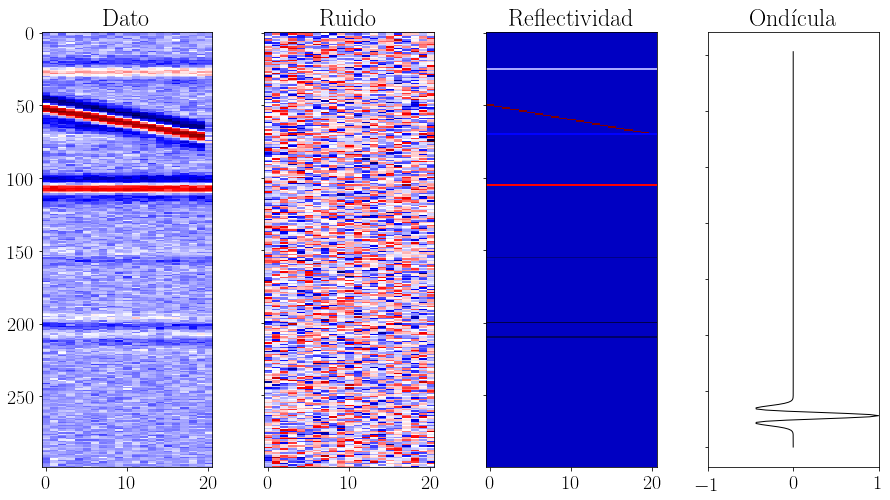

In [141]:
dt=0.002
m=(wl-1)/2
colormap = 'seismic'# defino el mapa de colores.
xfin = d.shape[0]
# para poner en referencia el tamaño de la ondícula:
long_wav = np.zeros(xfin)
long_wav[0:wl] = wavelet[:,0]


fig, ax = plt.subplots(1,4,figsize=(15,8))  # base x altura 
plt.subplots_adjust(wspace =0.3,hspace=0.9) # espacio entre graficos
    
ax[0].set_title('Dato')
ax[1].set_title('Ruido')
ax[2].set_title('Reflectividad')
ax[3].set_title( r'Ond\'icula')

[ax[i].set_xticks(np.arange(0,21,10)) for i in range(0,3)]
[ax[i].set_yticklabels([]) for i in range(1,4)]

ax[0].imshow(d[m:-1-m,:],aspect='auto',cmap=colormap)


ax[1].imshow(ruido[m:dl-m,:] ,aspect='auto', cmap=colormap)


ax[2].imshow(R, aspect='auto', cmap=colormap)

    
ax[3].plot(long_wav,np.arange(0,xfin)*dt,'k')
ax[3].set_xlim([-1,1])
  
#fig.savefig('sintetico.pdf', bbox_inches='tight') # descomentar si se quiere guardar la figura.
plt.show()
